# Lab:  Source Localization for EEG

EEG or [Electroencephalography](https://en.wikipedia.org/wiki/Electroencephalography) is a powerful tool for neuroscientists in understanding brain activity.  In EEG, a patient wears a headset with electrodes that measures voltages at a number of points on the scalp.  These voltages arise from ionic currents within the brain.  A common *inverse problem* is to estimate the which parts of the brain caused the measured response.  Source localization is useful in understanding which parts of the brain are involved in certain tasks.  A key challenge in this inverse problem is that the number of unknowns (possible locations in the brain) is much larger than the number of measurements.  In this lab, we will use LASSO regression on a real EEG dataset to overcome this problem and determine the brain region that is active under an auditory stimulus.

In addition to learning the concepts in the demo for this unit, you will learn to:
* Represent responses of multi-channel time-series data, such as EEG, using linear models
* Perform LASSO and Ridge regression
* Select the regularization level via cross-validation
* Visually compare the sparsity between the solutions

We first download some standard packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

## Load the Data

The data in this lab is taken from one of the sample datasets in the [MNE website](https://martinos.org/mne/stable/index.html). The sample data is a recording from one subject who experienced some auditory stimulus on the left ear.    

The raw data is very large (`1.5G`) and also requires that you install the `mne` python package. To make this lab easier, I have extracted and processed a small section of the data.  The following commands will get the data from a `pickle` file `eeg_dat.p` stored remotely.

In [3]:
import cloudpickle
from urllib.request import urlopen
with urlopen("http://www.ece.ohio-state.edu/~schniter/nonpublic/eeg_dat.p") as fp:
    [Xtr,Ytr] = cloudpickle.load(fp)

To understand the data, there are three key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Current is measured at each brain region (called a *voxel*) in three separate directions: `x`, `y`, and `z`.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices are:
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.

Using `X.shape` and `Y.shape` compute and print `nt`, `nchan`, `ncur` and `nvoxels`.

In [4]:
# TODO
# nt = ...
# ncur = ...
# nchan = ...
# nvoxels = ...

nchan,ncur = Xtr.shape
nchan,nt = Ytr.shape
nvoxels = ncur // 3

print('Number of time steps that we measure data   = %d' % nt)
print('Number of channels measured in each time step = %d' % nchan)
print('Number of currents in the brain = %d' % ncur)
print('Number of current in each voxel = %d' % nvoxels)


Number of time steps that we measure data   = 85
Number of channels measured in each time step = 305
Number of currents in the brain = 22494
Number of current in each voxel = 7498


## The need for Regularization

Our goal is to estimate the currents `W` in the brain from the measurements `Y`.  We will use the linear model

    Y[i,k]  = \sum_j X[i,j]*W[j,k]+ b[k]

where `W[j,k]` is the value of current `j` at time `k` and where `b[k]` is a bias.  We can solve for the current matrix `W` via linear regression.  

Note that this model differs slightly from the linear regression model that we considered in most of the lectures, in the following sense. At sample index `i`, the target is a *vector* `Y[i,:]` (not a scalar `y[i]`). Thus, the regresson coefficients `W[j,:]` must also be *vectors* (rather than a scalars `w[j]`) and the bias `b[:]` must also be a *vector* (rather than a scalar `b`).  In other words, if we considered only a *single* value of `k` in the above model, then we would get a scalar-target model that takes the form `y[i] = \sum_j X[i,j]*w[j] + b`.  But in this lab, we have several values of `k`.

However, there is a major problem:
*  There are `nt` times `ncur` unknowns in `W`
*  There are `nt` time `nchan` measurements in `Y`
*  `ncur` is much larger than `nchan`

In other words, we have

    number of unknowns >> number of measurements
    
In this case, the least-squares solution is not unique (and the matrix we'd like to invert when computing the least-squares solution is not invertible).  We can remedy this problem using regularization.  We first try Ridge regression, and later LASSO.

## Ridge Regression

First, standardize the features using the `StandardScaler` object from `sklearn`.

In [5]:
#TODO
# Xtr =
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtr)

Next, train a Ridge regression model using a regularization weight of `alpha=1` using the `Ridge` object from `sklearn`.
Then compute the `R^2` value on the training data using the `r2_score` function and print it out.
It should be relatively large.

In [6]:
# TODO
# rsq_tr = 
regr = Ridge(alpha=1)
regr.fit(Xtr,Ytr)
Yhat = regr.predict(Xtr)
rsq_tr = r2_score(Ytr, Yhat)
print('R^2 training = %7.4f' % rsq_tr)


R^2 training =  0.9366


Now use `cross_val_score` to compute the `R^2` value using shuffled 5-fold cross-validation.  Use a fixed random seed for consistency across experiments.
You should see that the cross-validated `R^2` value is very low.
Remember that cross-validation aims to estimate the performance of a model on unseen test data.
The fact that the training `R^2` is high and the test `R^2` is low means that this model is over-fitting.

In [7]:
#TODO 

from sklearn import linear_model
kf = KFold(n_splits=5,shuffle=True,random_state=0)

rsq_cv = cross_val_score(regr, Xtr, Ytr, scoring = 'r2',cv=kf)
rsq_cv = np.mean(rsq_cv)
print("Cross-Validation R2 = " , rsq_cv)

Cross-Validation R2 =  -1.91768414165402


Next, try to see if you can get a better `R^2` score using a different value of `alpha`.  
In particular, use 2-fold cross-validation to find the largest `R^2` for 20 `alpha` values logarithmically spaced from `10^3` to `10^6` (use `np.logspace()`), as well as the maximizing value of `alpha`. 
Use `GridSearchCV` for this task with the appropriate scoring choice.

In [8]:
# TODO

ridge = linear_model.Ridge(fit_intercept=False)
alphas_ridge = np.logspace(3,6,20)

parameters = {'alpha':alphas_ridge}
gscv = GridSearchCV(ridge, parameters, cv=kf, scoring='r2')
gscv.fit(Xtr,Ytr)
rsq_cv = gscv.cv_results_['mean_test_score']
imax = np.argmax(rsq_cv)
alpha_max = alphas_ridge[imax]
rsq_cv_ridge = rsq_cv[imax]
print(rsq_cv_ridge)
print(alpha_max)

0.265703089447204
8858.667904100823


Plot the cross-validation `R^2` vs. `alpha` and mark the maximum `R^2` and maximizing `alpha`.  You should see that the maximum `R^2` is much better than with `alpha=1`.

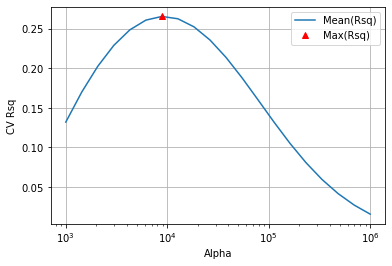

In [9]:
# TODO
plt.semilogx(alphas_ridge, rsq_cv, label='Mean(Rsq)')
plt.semilogx(alpha_max, rsq_cv_ridge, 'r^', label='Max(Rsq)')
plt.legend(loc='upper right')
plt.xlabel('Alpha')
plt.ylabel('CV Rsq')
plt.grid()
plt.show()

Now, let's take a closer look at the solution. 
* Extract the matrix `W` of optimally tuned ridge coefficients from the output of GridSearchCV.  These are stored in `best_estimator_.coef_` in transposed form, so apply a transpose to get `W` as we defined it above.
* For each current `j` compute `Wrms[j] =  sqrt( sum_k W[j,k]**2 )`, which is the root-mean-squared value across time.
* Finally, plot the `Wrms` vector.

You will see that the RMS current vector `Wrms` is not sparse.  This means that the solution found by Ridge regression allows non-zero currents in all locations.

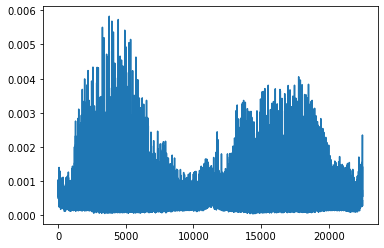

In [11]:
# TODO
#
#W_ridge = ...
#W_ridge_rms = ...
W_ridge = np.transpose(gscv.best_estimator_.coef_)
W_ridge_rms=np.sqrt(np.sum((W_ridge)**2,axis=1))
plt.plot(W_ridge_rms)



## LASSO Regression

We can improve the estimate by setting a large fraction of the coefficients to zero.  Biologically, we expect that only a limited number of brain regions should be involved in the response to a particular stimuli.  As a result, we expect that the current matrix `W[j,k]` should be zero-valued for most locations `j` at each time `k`.  We can find such a solution using LASSO with an appropriate regularization strength `alpha`.

First, fit a LASSO model to the training data with `alpha=1e-2`.  In sklearn's `Lasso`, set `max_iter=100`, `tol=0.01`, and `warm_start=True` to speed things up.  The LASSO solver is much slower than the Ridge solver, so this may take a minute.

In [12]:
# TODO
regr = Lasso(alpha = 1e-2, max_iter=100, tol=0.01, warm_start=True)
regr.fit(Xtr,Ytr)

Lasso(alpha=0.01, max_iter=100, tol=0.01, warm_start=True)

Next, estimate the `R^2` value using the same 5-fold cross-validation object you created earlier using `cross_val_score`.  Be patient as this may take a few minutes.  You should get a better `R^2` than you did with Ridge regression.  

In [13]:
# TODO
#rsq_cv = 
rsq_cv = cross_val_score(regr, Xtr, Ytr, scoring = 'r2',cv=kf)
print(rsq_cv)
rsq_cv = np.mean(rsq_cv)
print("Cross-Validation R2 = " , rsq_cv)

[0.24606967 0.43590823 0.38021013 0.41329823 0.35038139]
Cross-Validation R2 =  0.3651735309862344


Still, the value `alpha=1e-2` was only a guess.  We should do even better with a properly tuned `alpha`. 

##  LASSO Feature Selection + LS Linear Regression

We know that LASSO does two things: it sets a subset of coefficients to zero and it shrinks 
the remaining coefficients towards zero. 
Since this coefficient shrinkage is often problematic, it is typical to use LASSO only for feature selection.
Once features are selected by LASSO, another regression method is applied to those features, such as LS-based linear regression.
We'll call this method "LASSO+LS".
It is also known as "debiased LASSO".

Your next task is use a grid search to tune `alpha` for LASSO+LS. 
For consistency, use the same shuffled 5-fold cross-validation object `kf` that you created earlier.
Make a log-spaced grid with 5 values. 
(It's up to you to choose the values.)
Then make a `for` loop over the grid values, doing the following for each `alpha`:
* Fit a LASSO model to the entire training data and identify the feature subset where the LASSO coefficients are non-zero.
* Print out `alpha` and the number of selected features
* Using those features, fit a least-squares model and evaluate the R^2 value using `cross_val_score`.
When you have done this for all grid points, plot the CV-estimated R^2 versus `alpha` and mark the maximum R^2 and maximizing value of `alpha`. 

Do the above several times for different choices of `alpha` grid until you find a grid where R^2 peaks in the middle and with fine enough grid resolution to identify a good R^2 value.
If you see lasso selecting zero features for some `alpha`, you know that value of `alpha` is too high.

alpha= 0.01 number of features= 1247 Rsquare= -5.927574109064643
alpha= 0.01778279410038923 number of features= 839 Rsquare= -7.120458586500663
alpha= 0.03162277660168379 number of features= 374 Rsquare= -17.45949743947068
alpha= 0.05623413251903491 number of features= 111 Rsquare= -0.010699442670432255
alpha= 0.1 number of features= 42 Rsquare= 0.3640475897059949


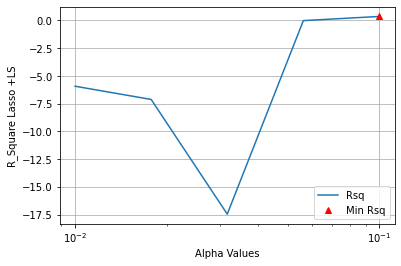

In [16]:
# To extract the feature subset...
#   nonzero = np.any(np.abs(lasso.coef_)>1e-5,axis=0)
#   subset = np.where(nonzero)[0] # array of feature indices
#
# TODO:
#
# alphas_lasso = ...
# for i,a in enumerate(alphas_lasso):
#    ...
#    rsq_cv[i] = ...
#
# plt.plot(...)

# lasso = Lasso(fit_intercept = False, max_iter=1000, tol=0.1, warm_start=True)
# alphas_lasso = np.logspace(-5,4,5)
# for i,a in enumerate(alphas_lasso):
#     lasso.set_params(alpha = a)
#     lasso.fit(Xtr,Ytr)
#     nonzero = np.any(np.abs(lasso.coef_)>1e-5,axis=0)
#     subset = np.where(nonzero)[0] # array of feature indices
#     print(a,len(subset))
#     rsq_cv = cross_val_score(lasso, Xtr, Ytr, cv=kf, scoring='r2')
#     rsq_cv[i] = np.mean(rsq_cv)
# imax = np.argmax(rsq_cv)
# alpha_max = alphas_lasso[imax]
# rsq_cv_lasso_ls2 = rsq_cv[imax]

# # Plot the mean MSE, the minimum MSE, and the mean MSE + 1 std dev
# plt.semilogx(alphas_lasso, rsq_cv, label='Mean(R2)')
# plt.semilogx(alpha_max, rsq_cv_lasso_ls2, 'r^', label='max(R2)')
# plt.legend(loc='upper left')
# plt.xlabel('alpha')
# plt.ylabel('CV MSE')
# plt.grid()
# plt.show()

alphas_lasso = np.logspace(-2,-1,5)

lasso=Lasso(max_iter=10000,tol=0.01,warm_start=True)

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# build pipeline for LASSO+FeatureSelect+LS
linear = LinearRegression(fit_intercept=False)

rsq_cv=np.zeros(len(alphas_lasso))
for i,a in enumerate(alphas_lasso):
    # fit LASSO
    lasso.set_params(alpha =a)
    lasso.fit(Xtr,Ytr)
    # select features
    nonzero = np.any(np.abs(lasso.coef_)>1e-5,axis=0)
    subset = np.where(nonzero)[0] # array of feature indices
    # fit LS and evaluate performance using CV
    rsqlasso = cross_val_score(linear,Xtr[:, subset], Ytr,cv=kf, scoring='r2')
    rsq_cv[i] = np.mean(rsqlasso)
    print('alpha=',a,'number of features=',len(subset), 'Rsquare=',rsq_cv[i])
    
imax=np.argmax(rsq_cv)
max_alpha=alphas_lasso[imax]
rsq_cv_lasso=rsq_cv[imax]
plt.semilogx(alphas_lasso,rsq_cv,label='Rsq')
plt.semilogx(alphas_lasso[imax],np.max(rsq_cv),'r^',label='Min Rsq')
plt.legend(loc='upper right')
plt.xlabel('Alpha Values')
plt.ylabel('R_Square Lasso +LS')
plt.legend(loc='lower right')
plt.grid()

You should see that LASSO+LS with a tuned `alpha` performs similarly to the untuned LASSO from earlier.

One reason that tuned LASSO+LS is not much better than untuned LASSO is that LASSO's coefficient shrinkage may actually be helping with this dataset.  Remember that Ridge regression is another method that shrinks coefficients, and it is known to help with correlated features.  The features in this dataset are definitely correlated, so perhaps we should try performing Ridge regression on LASSO-selected features.

Before we do that, though, let's plot the RMS values of the biased LASSO coefficients (at the optimal `alpha`), similarly to how you plotted the Ridge coefficients earlier. 
To do this, you'll first need to re-fit LASSO and LASSO+LS.

In addition, let's also plot the RMS values of the LASSO+LS coefficients for comparison.
Note that the LS estimator returns only the values of the few nonzero weights selected by LASSO. 
So, to plot the LASSO+LS coefficients, you'll need to first make an all-zeros array and then insert the LS weights in the locations of the selected features.

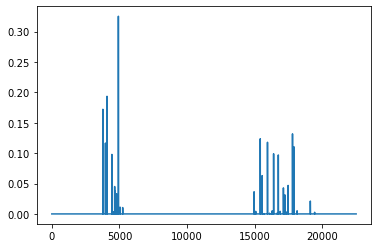

In [19]:
# TODO
#
#W_lasso = ...
#W_lasso_rms = ...
#W_lassols = ...
#W_lassols_rms = ...

imax=np.argmax(rsq_cv)
max_alpha=alphas_lasso[imax]
lasso1=Lasso(alpha=max_alpha,max_iter=1000,tol=0.01,warm_start=True)
lasso1.fit(Xtr,Ytr)
W_lasso=np.transpose(lasso1.coef_)
W_lasso_rms=np.sqrt(np.sum(W_lasso**2,axis=1))
plt.plot(W_lasso_rms)


14.634257383435488

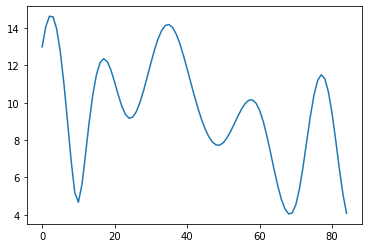

In [21]:
nonzero = np.any(np.abs(lasso1.coef_)>1e-5,axis=0)
subset = np.where(nonzero)[0] # array of feature indices
linreg=LinearRegression(fit_intercept=False)
linreg.fit(Xtr[:, subset], Ytr)
Wlsrms=linreg.coef_
Wlsrms=np.sqrt(np.sum(Wlsrms**2,axis=1))
plt.plot(Wlsrms)
np.max(Wlsrms)

The LASSO and LASSO+LS weights should be very sparse.
The LASSO weights should be shrunk compared to the LASSO+LS weights but have the same support (i.e., the same subset of nonzero indices)

##  LASSO Feature Selection + tuned Ridge Regression

We will now try to improve upon the previous methods by using LASSO+Ridge instead of LASSO+LS.  At each fixed value of `alpha_lasso` that we try, we will do a grid-search-CV optimization of `alpha_ridge`.

Modify your previous code so that `cross_val_score(linreg...` is replaced by `gscv.fit(...`, where `gscv = GridSearchCV(ridge...`.  In other words, for each value of `alphas_lasso`, do a grid-search over an `alphas_ridge` grid using `GridSearchCV`, and then extract the results using `gscv.best_score_` and `gscv.best_parameters_['alpha']`.
For `alphas_ridge`, I suggest to start with `logspace(0,4,5)`. 

Plot the resulting R^2 versus `alphas_lasso`.  Iterate on your choice of `alphas_lasso` until R^2 peaks in the middle of your `alphas_lasso` grid and there is enough resolution to identify a good value.

Once you have found a good choice for `alphas_lasso`, plot R^2 versus `alphas_ridge` to see if `alphas_ridge` needs adjusting, and adjust it as needed.

Alpha =  0.0001 and Features is 22473
Alpha =  0.0005623413251903491 and Features is 21014
Alpha =  0.0031622776601683794 and Features is 10348
Alpha =  0.01778279410038923 and Features is 1390
Alpha =  0.1 and Features is 71


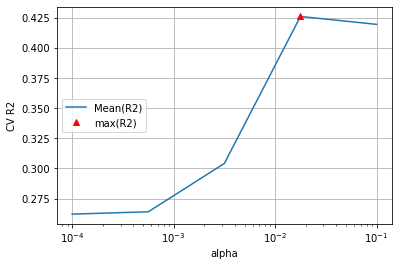

In [22]:
# TODO
ridge=Ridge()
rsq=[]
score=[]
alpha=[]
# TODO:
lasso = Lasso(fit_intercept=False,warm_start=True,max_iter=1000,tol=0.1)
alphas_lasso = np.logspace(-4,-1,5)
alphas_ridge = np.logspace(0,4,5)
params_grid = {'alpha':alphas_ridge}
for i,a in enumerate(alphas_lasso):
  lasso.set_params(alpha=a)
  lasso.fit(Xtr,Ytr)
  nonzero = np.any(np.abs(lasso.coef_)>1e-5,axis=0)
  subset = np.where(nonzero)[0]
  print('Alpha =  {} and Features is {}'.format(a,len(subset)))
  gscv = GridSearchCV(ridge,params_grid , cv=kf, scoring='r2')
  gscv.fit(Xtr[:,subset],Ytr)
  lasso_ridge = gscv.cv_results_['mean_test_score']
  #print(lasso_ridge)
  #print(np.mean(lasso_ridge))
  rsq.append(np.mean(lasso_ridge))
  best_score = gscv.best_score_
  best_alpha_params=gscv.best_params_['alpha']
  score.append(best_score)
  alpha.append(best_alpha_params)

index=np.argmax(score)
r2_max = score[index]
alpha_max = alphas_lasso[index]
plt.semilogx(alphas_lasso, score, label='Mean(R2)')
plt.semilogx(alpha_max, r2_max, 'r^', label='max(R2)')
plt.legend(loc='center left')
plt.xlabel('alpha')
plt.ylabel('CV R2')
plt.grid()
plt.show()

You should see that (tuned) LASSO feature selection followed by tuned Ridge regression outperforms all previous methods: Ridge, LASSO, and LASSO+LS.

## More fun

If you want to dive deeper into this application:
* Install the [MNE python package](https://martinos.org/mne/stable/index.html).  This is an amazing package with many tools for processing EEG data.
* In particular, you can use the above to visualize where in the brain the currents are active.
* We could also use a more sophisticated regularization technique called Group LASSO, that encourages *entire rows* of the `W` matrix to be zero-valued.  This is appropriate in this application because, if the current is zero for one time, it is likely to be zero for all time. 
* You can even use the recovered current patterns to make predictions about what the patient is seeing or hearing or thinking!  It sounds like science-fiction, but it has been demonstrated to work to a certain extent!